In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Preprocessed Data

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 43.6 MB/s 
     |████████████████████████████████| 636 kB 40.9 MB/s 
     |████████████████████████████████| 3.3 MB 41.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
from transformers import GPT2LMHeadModel, GPT2Config, BertTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup
import random
import os
import time
import datetime


In [ ]:
%cd /content/drive/MyDrive/KUBIG/NLP/KUBIG Project

/content/drive/MyDrive/KUBIG/NLP/KUBIG Project


In [ ]:
!ls

full_indie_noenglish.csv  Indie-fine-tuning.ipynb


# 힙합, 인디에 따라서 주석 바꿔야 됨!

In [ ]:
ind_df=pd.read_csv('full_indie_noenglish.csv',encoding='utf-8')
ind_df.head()
# hip_df=pd.read_csv('full_hiphop.csv',encoding='utf-8')
# hip_df.head()


,Unnamed: 0,제목,가사
0,0,너를 좋아하니까,<인디>넌 여기 있는데 손 닿을 수 있는 바로 내 앞에 여기에 넌 생각하겠지 내가 ...
1,1,그대 보고 싶어요,<인디>시간이 흘렀어도 난 아직 그대로 같은 곳에서 그댈 기다리고 있죠 그대가 내 ...
2,2,와인 토킹 (Feat. Ra.l),<인디>창밖을 내다보니 비가 그치지 않아 너와 함께 맞이한 편안한 밤 촛불은 켜져 ...
3,3,Come On Closer,<인디> 너랑 친해지고 싶은데 넌 왜 나를 자꾸 외면해 어떻게 하길 원해 너랑 얘기...
4,4,불여우,<인디>자주 못 보는 절세 미인이 날 보며 미소를 짓고 난 기절할 뻔 이미 마법에 ...


In [ ]:
df=ind_df

In [ ]:
len(ind_df)
# len(hip_df)

3837

In [ ]:
lyrics_df=ind_df['가사']
# df=hip_df['가사']

In [ ]:
lyrics_df.head()

0    <인디>넌 여기 있는데 손 닿을 수 있는 바로 내 앞에 여기에 넌 생각하겠지 내가 ...
1    <인디>시간이 흘렀어도 난 아직 그대로 같은 곳에서 그댈 기다리고 있죠 그대가 내 ...
2    <인디>창밖을 내다보니 비가 그치지 않아 너와 함께 맞이한 편안한 밤 촛불은 켜져 ...
3    <인디> 너랑 친해지고 싶은데 넌 왜 나를 자꾸 외면해 어떻게 하길 원해 너랑 얘기...
4    <인디>자주 못 보는 절세 미인이 날 보며 미소를 짓고 난 기절할 뻔 이미 마법에 ...
Name: 가사, dtype: object

In [ ]:
gens=["<인디>"] 
# gens=["<힙합>"]

tokenizer_gpt3 = BertTokenizerFast.from_pretrained("kykim/gpt3-kor-small_based_on_gpt2", 
                                                   bos_token='<|startoftext|>', # begin of string [bos] token
                                                   eos_token='<|endoftext|>',  # end of string  [eos] token
                                                   pad_token='<|pad|>', # padding token
                                                   additional_special_tokens=gens)
 
tokenizer_gpt3.add_tokens("<br>")

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'BertTokenizer'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer_gpt3.model_max_length)) # embedding size 체크
print("The beginning of sequence token {} token has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.bos_token_id), tokenizer_gpt3.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.eos_token_id), tokenizer_gpt3.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.pad_token_id), tokenizer_gpt3.pad_token_id))

The max model length is 2048 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 42000
The end of sequence token <|endoftext|> has the id 42001
The padding token <|pad|> has the id 42002


In [ ]:
df.iloc[0]

Unnamed: 0                                                    0
제목                                                     너를 좋아하니까
가사            <인디>넌 여기 있는데 손 닿을 수 있는 바로 내 앞에 여기에 넌 생각하겠지 내가 ...
Name: 0, dtype: object

In [ ]:
# 하나만 잘 돌아가는지 확인
ex=lyrics_df.iloc[0]

In [ ]:
outputs=tokenizer_gpt3.encode('<|startoftext|>'+ex+'<|endoftext|>', 
      truncation=True, max_length=768, padding="max_length")[1:]

In [ ]:
for i in outputs:
  print(tokenizer_gpt3.convert_ids_to_tokens(i))

<|startoftext|>
<인디>
넌
여기
있는데
손
닿을
수
있는
바로
내
앞에
여기에
넌
생각
##하겠
##지
내가
왜
얘기
않는
##지
하지만
아무
말도
할
수
없었
##어
오
그대
때문에
이제
내
마음
감
##출
순
없지만
그대
눈을
볼
때면
난
다시
말을
잃
##어
버리
##네
나의
슬픈
사랑
##아
얼마나
네
손을
잡고
싶
##었
##었는지
얼마나
너
##와
함께
걷고
싶
##었는지
혹시
아니
내가
왜
이렇게
얘기
##하는지
난
너를
좋아
##하니까
길을
걷
##다가
연인
##들이
내
곁
##을
스
##치면
사무
##치는
그리
##움
하지만
아직도
난
너
##에게
다가
##갈
수
없어
날
보여주기
힘들어
너
##와
함께
있으면
얼마나
네
손을
잡고
싶
##었
##었는지
얼마나
너
##와
함께
걷고
싶
##었는지
혹시
아니
내가
왜
이렇게
얘기
##하는지
난
너를
좋아
##하니까
닫
##힌
너의
마음에
가까이
다가가
##긴
힘들지만
내
맘
보여준다
##면
나를
이해할
수
있겠
##니
슬픈
나의
사랑
##아
얼마나
네
손을
잡고
싶
##었
##었는지
얼마나
너
##와
함께
걷고
싶
##었는지
혹시
아니
내가
왜
이렇게
얘기
##하는지
난
너를
좋아
##하니까
얼마나
네
손을
잡고
싶
##었
##었는지
얼마나
너
##와
함께
걷고
싶
##었는지
혹시
아니
내가
왜
이렇게
얘기
##하는지
난
너를
사랑
##하니까
<|endoftext|>
[SEP]
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>
<|pad|>

# Torch Dataset Customizing

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Config
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list: # 노래 별로 encode후, tensor로 만들어서 배열에 넣음

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                        truncation=True, max_length=max_length, 
                                        padding="max_length") 

      self.input_ids.append(torch.tensor(encodings_dict['input_ids'][1:])) # cls 제거
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask'][1:])) # cls 제거
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
len(lyrics_df)

3837

In [ ]:
# 전처리한 가사 리스트(lyrics_df)에 대해 파이토치 데이터셋 생성

dataset=GPT2Dataset(lyrics_df,tokenizer_gpt3,max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,453 training samples
  384 validation samples


In [ ]:
train_dataset

In [ ]:
# 토치 데이터 로더
batch_size = 2 # 서버에서 돌리면 다르게 설정해도 될듯
# GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. 
# This can be mitigated by accumulating the gradients but that is out of scope here.

# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Fine Tuning

In [ ]:
# # I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('kykim/gpt3-kor-small_based_on_gpt2', output_hidden_states=False)

# # instantiate the model
model = GPT2LMHeadModel.from_pretrained("kykim/gpt3-kor-small_based_on_gpt2")

Downloading:   0%|          | 0.00/526M [00:00<?, ?B/s]

In [ ]:
len(tokenizer_gpt3)

42005

In [ ]:
# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer_gpt3))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps 
#예로 사용한 데이터셋이 작아서 sample_every : 문장생성을  100 -> 20step 마다로 바꿔봤음!
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )
                

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# 학습 진행되면서 learning_rate 바뀌면서 학습 빠르게 진행되도록 해줌.

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
for step, batch in enumerate(train_dataloader):
  print(step,len(batch),'batch[0] :',batch[0],'batch[1] :',batch[1])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        [42000, 42003, 35555,  ..., 42002, 42002, 42002]]) batch[1] : tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
96 2 batch[0] : tensor([[42000, 42003, 17917,  ..., 42002, 42002, 42002],
        [42000, 42003, 28889,  ..., 42002, 42002, 42002]]) batch[1] : tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
97 2 batch[0] : tensor([[42000, 42003,  5156,  ..., 42002, 42002, 42002],
        [42000, 42003, 20350,  ..., 42002, 42002, 42002]]) batch[1] : tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
98 2 batch[0] : tensor([[42000, 42003, 16098,  ..., 42002, 42002, 42002],
        [42000, 42003,  2787,  ..., 42002, 42002, 42002]]) batch[1] : tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
99 2 batch[0] : tensor([[42000, 42003,  3056,  ..., 42002, 42002, 42002],
        [42000, 42003, 27723,  ..., 42002, 42002, 42002]]) batch[1] : tensor([[1, 1, 1,  ..., 0, 0, 0],
        

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device) 

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device) # GPU 입력으로 사용될 tensor는 모두 to(device) 필요
        b_labels = batch[0].to(device) # ? 라벨? 마스크?
        b_masks = batch[1].to(device) # ? 

        model.zero_grad()        # 변화도(Gradient) 매개변수를 0으로 만들고

        outputs = model(  b_input_ids,  # loss를 출력하는지 확인.
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None 
                        )
 
        loss = outputs[0]  
        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0) # elapsed : 지난 시간 출력.
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval() # 학습 반영안되도록. generate 할때는? 잘 모르겠음.

            sample_outputs = model.generate( # 세대 토큰 넣어서 해봄, 눌러서 살펴보면 어떻게 쓰는지 나옴
                                    bos_token_id=random.randint(1,30000),  # The id of the beginning-of-sequence token. 랜덤한 단어로 시작하는 것.
                                    do_sample=True,# Whether or not to use sampling ; use greedy decoding   
                                    top_k=50, # The number of highest probability vocabulary  tokens to
                                    max_length = 200, # The maximum length of the sequence to be generated.
                                    top_p=0.95, # If set to float < 1, only the most probable tokens with probabilities that add up to top_p or higher are kept for generation.
                                    num_return_sequences=1, # The number of independently computed returned sequences for each element in the batch.
                                    repetition_penalty=2.0, 
                                
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True))) # id를 decode해서 문장으로 출력
            
            model.train() # train은 일정 sample_every step마다 하는듯.
        
        # 여긴 뭐 학습하는과정? 역전파 등등.

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():     # 학습 반영안되도록.

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append( # 바로 밑에서 쓰임. 정확도가 올라가는지 시각화할때 사용할듯
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  1,727. Loss: 0.6529645919799805.   Elapsed: 0:01:33.
0: 진공이 흐르면서 공기층이 발생하므로 공기가 팽창하면 체온의 증가와 호흡수의 저하, 수분 섭취 과다증상 등이 나타날 수 있다는 것이다.


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  1,727. Loss: 0.6504250764846802.   Elapsed: 0:03:06.
0: 뜰 수 있는 시간들이 많아질 때라는 생각에.


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  1,727. Loss: 0.45252931118011475.   Elapsed: 0:04:39.
0: [unused815] 너를 만나기 위해 난 떠났지만 니가 있어서 너무 좋았어 내가 정말 가고 싶었던 곳이었는데 너와 나로 구성된 그곳을 또 왔구나 네가 그리워서 간 곳인데 네게 딱 어울리는 장소가 아니였어 나도 모르게 내 맘속에 담아둔 너의 이야기 넌 언제나 내게 이렇게 나를 생각했지 그댈 사랑했었어 나는 늘 그랬듯이 널 잊는 거야 그리고 너는 항상 나의 곁으로 있었고 그래서 우린 서로에게 위로를 주고받으며 이 밤도 잘 이겨냈고 이제는 날 용서해 줄 시간이야 하지만 여전히 나에게 있어선 우리 서로를 잊어버리는 건 어려운 일인 것 같아 사실 우리는 서로의 마음 속에 담겨있는 한구석에 서 있고 싶어서 그래 오늘도 내일만을 기다리며 저 문을 열고 하루를 살며시 열어봤지만 아직 모든 게 다 익숙하지 않아서 그런지 낯설지도 않아 아직도 익숙치 않고 어색한데 왜 그럴까 아무리 봐도 모르는걸 어떡해야 해 도대체 어떻게 해야 하는 걸까 그냥 이대로 그대로 멈춰있자 그런 말 그만 하자 그게 그렇게 어려워서 그렇지 다른 사람과 함께 있는다면 그건 행복한 일이 아니라니까 지금 당장이라도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  1,727. Loss: 0.4891664981842041.   Elapsed: 0:06:16.
0: 정리를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  1,727. Loss: 2.245724678039551.   Elapsed: 0:07:49.
0: ##젓 난 왜 너를 이렇게 또 미워할까요 그대는 내 맘이란 걸 모르는 건가 그런 널 싫어해 내가 너와 함께 있는 이유 그 어떤 것도 나에게 의미를 주지 못한다면 그게 나밖에 없는데 나의 눈물이 더 많아진다 해도 너는 여전히 나를 좋아하고 사랑해 나만 사랑한다는 건 아니겠지만 너의 마음은 항상 내게 위로를 주는데 네가 다시 볼 때면 꼭 다른 게 있어 날 찾아줘 오늘도 멋진 하루 되렴 언제나 우린 변함없는 사랑을 나누며 사는구나 우리 모두 좋은 꿈을 꿔 우리의 꿈은 늘 그래왔으니까 나는 이 모든 일이 너무 좋잖아 그리고 네게서 오는 꿈들과 수많은 것들에 대해 이젠 아무것도 아닌 것 같아 조금 아쉬운 것만 같다가도 언젠가 또다시 후회하진 않아 조금은 괜찮아졌으면 좋겠어 하지만 그건 그렇게 되지 않을 거야 어쩌면 그때까지 그대로 계속을 바라볼 테니까 혹시 지금 나와 같은 생각을 하고 있다면 오늘처럼 매일이 행복할 순 없는 건지 아니면 내일도 똑같기를 원하는지 그냥 흘러가는 기분이 다 똑같은 마음이겠죠 가끔은 이런 생각들도 때론 참 괜찮은 거 같다는 생각도 가끔 해보곤 하는데 누군가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  1,727. Loss: 0.46075573563575745.   Elapsed: 0:09:26.
0: ##사 이 두 번 내던진 나를 이젠 잊지못해 눈물의 마지막 날 너의 얼굴 다시 찾을 수 없을지도 몰라 이런 내게 너는 언제나 널 걱정스런 얼굴로 바라볼 수도 있어 이렇게 아픈 나에게도 네가 있기에 난 네게 너무 벅차 아무것도 아닐거라 믿어왔었잖아 너에게 너무나 멀어져 아무 생각 안하게 되어 버린 나의 순간 내가 너를 더 많이 사랑하고 있을까 우리 둘이 같이 있든 어디있든지 나는 니가 늘 사랑하던 그 모습에 모든 걸 다 주고 싶은 마음뿐이야 정말 싫어졌어 사랑이란 건 참 힘든 것 같아 사랑에는 끝이 없대도 오늘따라 자꾸 아파 보여 조금만 기다려줘 오늘도 사랑해 영원히 이대로 돌아와라 제발 내일부터 괜찮아져 줘 사랑은 끝까지 가는거야 모두 끝나 버려 함께 했던 날이 그리워서 어떡하면 좋겠니 혹시 알고 있지 못한가요 나만 몰랐던 건가요 사랑하는 사람을 위해 얼마나 많은 사랑을 주었는지 너도 나도 알았지 어쩌면 넌 나 아닌 거 같은걸 어떻게 모른척했었지 어떤 의미일까 우린 서로 미워할 때 서로를 위해서 우리는 항상 슬퍼한다 말해오던 것처럼 그땐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  1,727. Loss: 0.5657512545585632.   Elapsed: 0:11:02.
0: 튠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  1,727. Loss: 0.556774377822876.   Elapsed: 0:12:35.
0: 붓 그대를 만나기 위해 떠나요 날 안아줘요 지금쯤 난 어디예요 내 사랑 노래를 들려준다면 그땐 어떻게 해야 할까요 이젠 내게 다시 없는 기억만을 남겨줄 건가요 이제는 나 이제 너를 만나서 울지마 그래 오늘부턴 혼자여도 좋아 널 보고 싶어 내가 있어 주던 많은 시간들을 모두 함께 해줘 이 세상에 하나밖에 없단다 이런 사랑이 있나 우리들은 잘 지내나 하루 종일 멍하니 누워 있을 수 밖에 모르는 걸 정말 이렇게 좋은걸 너와 같은 세상이 있다면 아마 다시는 올 수가 없을 거야 우린 너무 빨리 도망가 버리는 것 같아 모든 게 다 소용없어 너도 같이 서러울거야 나를 깨워 줘 그댈 만나면 넌 어떤 말을 할 건지도 알잖아 더 이상 너의 앞에 가질 말 없어 기다려 줄게 기다릴지 모를 시간이라 생각해 또 밤 열여섯에 니가 와서 눈을 떠주고 나면 나는 아무 말도 없이 자꾸만 잠이 와 내일을 위한 노래 네 손을 잡아 볼래 따뜻한 물 한잔 나눠마셔봐 어느새 시간은 흘러가고 점점 멀어지는데 여전히 작은 웃음만이 스쳐 갈


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  1,727. Loss: 0.35178524255752563.   Elapsed: 0:14:12.
0: 유난 봄기운이 가득하게 느껴지는 날이군요 벚꽃이 피어날 무렵이면 그 때가 떠오르는 건 어쩌면 제 마음과 같습니다 봄이 왔으면 좋을텐데 봄을 안 맞으니까 왠지 슬퍼보이네요 아 괜히 마음이 어지럽습니다 그대의 마음도 알 것 같고 따스한 햇살마저도 내 맘을 빼앗아가네 겨울이 와보니 이제 가을이라 할 법도 한데 나는 계절은 아직 살아 있는데 추위가 많이 불어서 그런가 감기와 싸우기는 또 싫어지네요 내가 계절이 지나도 따뜻한지 알아요 차가운 세상 찬바람과 맞서며 살고 싶어요 바람이 부는 날에는 날 안아주고 싶네요 꽃 피는 날에 나도 함께 손잡고 봄에 물들고 다시 겨울로 가네요 나 혼자라는 걸 알면 난 더 추워지는 겨울을 기다릴 거에요 이 꽃이 필 때에 따뜻해지겠죠 사랑이 오겠지만 그래도 사랑은 영원하지 않아요 이런 게 사랑을 하고 싶죠 우에우엔 이렇게 예쁜 나의 여린 손을 잡을 수 있게 해줘 사랑하는 모든 사람의 간절한 염원들 속에 나만 남겨둘께요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  1,727. Loss: 0.788093090057373.   Elapsed: 0:15:48.
0: 뒙 한 번 더 마주친 건 내가 널 싫어한 거야 네가 나 좋아하기 전에 나를 좋아해줘 그땐 또 내 맘에 들까 너와 함께라면 행복할 거라 생각해 넌 나에게 항상 고마워했는데 이번엔 정말 그래 이렇게 너를 잊어 버려서 참아내던 네 마음 다시 한번 돌아보자 나는 난 아직도 너는 너무 많은 말들을 쏟아내고 있어 나만 미워하면 안 되는 걸 알면서도 너의 손을 잡고 모든 게 이뤄지고 있는데 왜 이러지 않을까 다른 사람들은 이해할 수 없는 것들만을 다 말하고 있는 걸까 우린 서로에 너무나 많이 갇혀져버린 것처럼 너도 나의 그 말이 진실인지 아닌지 헷갈리게 돼 이제는 나도 날 잊을 수가 없어 매일 기다려도 알 필요 없이 지금을 떠올리는 건데 어쩜이야 이젠 용서를 못 받을 만큼 두려워하지 말아라 이 사랑은 내게 영원히 변치 않을 진심인걸 이제 우리도 영원한 사랑을 약속하고 있지만 아직 끝나지 않은 것 같은데 언제부턴가 자꾸만 니가 보고 싶어 우리 이별은 영원할지 몰라 다시는 돌이킬 수도 없었던 사랑인데 혹시 미안해 이런 말을 할까 괜히 우울해 이대로 끝내


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  1,727. Loss: 0.5416187047958374.   Elapsed: 0:17:25.
0: 후드


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  1,727. Loss: 0.43534234166145325.   Elapsed: 0:18:58.
0: ##할때는 너의 목소리만 들려도 너에게 들키면 넌 싫어하고 싶어 그댈 사랑한단 걸 알고 있었지만 왠지 난 네가 좋아 다른 사람의 시선들은 아무렇지도 않은데 너는 왜 그렇게 나를 바라볼까 아마 모든 게 다 똑같아 보여서 나도 모르게 자꾸 떠올랐던 기억들을 다시 보고 싶었어 사실 그런 생각들로 너를 그려서 내 마음이 아닌 듯 했지만 그냥 그래 널 생각해 그게 아니야 그래도 괜찮아 계속 봐줄게 니가 그랬었잖아 니 옆에 있던 사람들에 대한 얘기를 꺼내며 나는 이렇게 말했어 이 말을 들을 때 마다 얼마나 기다렸는지 이제 생각이 났어 아직도 조금의 후회가 남아있는지 그때 까지 기다려 줘 언제나 내가 있는 한 우린 함께 할 수 있을 거야 하지만 언제까지나 이런 마음일 줄은 몰랐었는데 이제야 알아봐 조금씩 더 가까워지는 서로의 눈빛이 닿을수록 점점 커지는 건 어쩌면 너무 당연한 것도 아닐까 하고 또 어느새 작은 곳에 갇혀버렸을 나의 모습도 자꾸만 커져 가는 마음을 어쩌지 못하네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  1,727. Loss: 0.803264319896698.   Elapsed: 0:20:34.
0: 스티커가 오늘밤은 유난히 어둡고 밤이 늦을 거 같아요 나른해 지는 날 아침에 너 혼자 방에 들어와 이불 위로 흩날리는 바람이 너무 좋아요 왠지 모르게 널 닮은 이 기분이 좋은 건 난 좋아 너는 사랑한다 이런 노래들은 그냥 흘러가는 시간에 젖어들게 될까 걱정 많이 했는데 그런 걱정하지 않을게요 우리 이렇게 한 여름 같은 내 마음 속에 너의 목소리가 들리길 기다려요 나는 네가 너무나 예뻐 그래서 정말 좋아한다면 내가 너를 만날 때 꼭 나를 안아줘 지금 여기 있는 모든 게 행복하길 바라던 나의 맘과 달리 왜 이러나 조금도 변하지 않는 우리의 마음과 네 맘이 달라진 거야 그저 시간이 지나면 괜찮아질 거라고 그렇게 생각했는데 사실 다 잘 맞는 건가 봐 조금은 마음이 무거워지더라 생각했었던 그 설레임 하나 없던 일들이 자꾸자꾸 생각나 이젠 떠나야 할 시간인 걸까 무슨 말을 해야 하는지 이제는 좀 알 것 같아 나에게 다가온 손길을 느낄 때면 함께 하고픈 사람이 있잖아 같이 있으면 좋을 텐데 아직은 아니야 지금은 말이야 아직이야 아직까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  1,727. Loss: 0.5878620147705078.   Elapsed: 0:22:11.
0: ##가지고 난 지금 이 순간의 모든 것은 꿈이니까 넌 그냥 너에게만 빠져들고 싶어 그대가 떠나면 나는 너무 외로울 것 같아 아무것도 모르고 내 곁을 떠났던 밤도 내게 말해줘 왜 내가 이러는 거야 이렇게 마음이 흔들릴까 너를 볼 수 있다면 다 날 사랑하지 않을테야 이제는 더 이상 널 보고 싶지 않아 이대로 눈을 감으면 나 어떡해 아무도 말 안 해 오늘 또 비가 내린대도 너의 마음 가득히 채워줄게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  1,727. Loss: 0.37529027462005615.   Elapsed: 0:23:46.
0: 넀 이 세상에 유일한 그대라는 그 어떤 의미론 없어도 나는 다른 사람이 필요하단 걸 너와 난 알고 있다고 넌 꼭 필요한가봐 내가 더 이상은 갈 곳을 몰라 니가 없으면 모든 게 무너져 버린대도 나를 떠나지 않아 우두커니 멍하니 서 있을래 아무 말 없이 조용히 너의 옆을 지켜보면서도 우린 매일 너를 보며 웃고 있는 것 뿐이야 널 두고간 내 마음 이젠 안 보이니까 그냥 가만히 옆에 네가 있어도 아무것도 할 수 없어 날 잊지 말아줘 나도 같이 살고 싶어 이런 나의 마음을 누가 알겠어 아무도 모르는 내게서 나와 함께 한 순간만 살아남는다면 그땐 어쩔줄 몰랐던 거지 또 나로 돌아선다 해도 우리 사랑하던 일들은 다 사라질게 아무리 많은 사람들이 와서 너도 나만 바라볼거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  1,727. Loss: 0.6373694539070129.   Elapsed: 0:25:21.
0: ##청정 저기 멀리 우리 작은방에 앉아서 우리는 한참을 얘기해 저 먼 하늘 위로 내가 찾던 너라는 걸 내게 넌 말하네 너의 눈에 비친 내 모습 이 모습은 모두 다 너를 위해 만든 거야 나는 널 좋아해 어제보다 더 행복해진 아침 난 이렇게 나를 찾아 왔네 우릴 보채는 날 붙잡은 나 때문에 오늘은 참 웃기 싫어 거울 앞을 바라보다가 눈을 감아요 언제나 같은 하루를 함께 보낸 그때의 추억들이 하나 둘씩 하나씩 나의 마음을 조금씩 채워줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  1,727. Loss: 0.4913415312767029.   Elapsed: 0:26:56.
0: ##틥 내게 말하네 왜 이러는 거냐고 물었지 나는 널 사랑한다 하지만 난 너 하나 뿐이라 더 이상 네게 아무 말도 할 수 없어 넌 내 곁에 있어 준대도 항상 나만을 응원할 테니 그 누구도 니 곁엔 없는 것 같다고 나에게 말하지 말라던 네가 이젠 나의 눈물처럼 다시 돌아와 나를 구해달라는 너의 말을 듣고 싶어 이제는 말할 곳이 필요해 이 때 니가 오면 우린 함께 울어버릴거라고 그때가 되면 모두 다 잊을 거라고 했던 말이 이제 끝인 줄 알았으니 정말 미안해서 너무 미워도 어쩌자고 그렇게 너를 바라보는 건지 몰라 어떻게 해서든 피할 수가 없다고 생각하겠지만 그건 착각이겠져 내가 아닌 다른 누군가를 위해서라면 그럴 수도 있지 그럼 우리는 또 무슨 꿈을 꾸고 있을까 우리의 꿈은 언제 어디서 시작해 끝이 날지 모를 그런 얘기들을 이렇게 들려줄 줄은 몰랐으니까 어쩌면 이미 알고 있을 지도 모르는 일이야 나 역시 이럴 때가 많아졌어 그냥 이대로 끝내자 그래도 너는 계속 그대만을 믿고 싶었겠지 사실

  Average training loss: 0.94
  Training epoch took: 0:27:24

Running Validation...
  Validation Loss: 0.67
  Validation took: 0:00:57

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  1,727. Loss: 0.6730760335922241.   Elapsed: 0:01:33.
0: [unused1037] 나는 너무 예뻐서 눈을 뗄 수가 없어요 하지만 그대만 내 맘을 원하는 건 아니에요 그댄 못 볼 것 같은데 어쩜 그럴 수 있어요 당신은 좀 특별해 보이나요 당신을 좋아해 주세요 내가 누군지 꼭 말해 줘요 정말 보고 싶단 말이에요 이런 나를 보는 많은 사람들이 나에겐 모두 다 필요 없어 보여요 그래요 그런 당신 같은 사람은 지금 어디에 있나요 혹시 또 이 밤이 지나면 아마 날 이해하겠니 이제 그만하면 돼 내게로 와줄래 너와 함께 있고 싶어서 어쩔 줄 모르겠어요 왜 이렇게 힘든 걸까요 그래도 괜찮아요 지금은 더 이상 울지마 않을 거예요 대신 나에게 올 거에요 우리 얘기 잘 들어 주고 있죠 이젠 끝나 버리고 싶어요 그렇게 생각하겠지만 괜찮아 나의 곁에 있으면 되는 거 잊지 말아요 다시는 다시 오지 않길 바래요 그럼 나와는 상관없어요 그건 조금 힘들겠죠 그렇지만 제발 나만의 방법으로 해봐요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  1,727. Loss: 0.5177136063575745.   Elapsed: 0:03:09.
0: [unused972] 너만 없다면 나는 좋겠어 그래 널 사랑하는 건 내가 더 좋아 그 모든걸 네 곁에서 함께 해줄게 내 품에 안겨 잠들 때면 또 다른 꿈을 꿀 수 있을 테니까 우리만의 추억을 만들겠니 이제 난 떠날거야 너를 보내줄 거야 나의 맘을 전할게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  1,727. Loss: 0.5253427624702454.   Elapsed: 0:04:43.
0: 늪 언제나 그렇듯이 우리의 사랑은 너무나 길고 멀어서 좀처럼 이루어지지 않고 있네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  1,727. Loss: 0.6391398310661316.   Elapsed: 0:06:16.
0: 턎 그대여 오늘 밤에 나는 꿈을 꾸고 또 하루를 살아요 나의 꿈과 같은 이 아침은 내 맘을 흔들어 놓고는 이렇게 잠이 들곤 해 오늘은 아주 조금도 피곤한 일이 아니에요 어제의 그 악몽들을 오늘도 그리고 내일로 가는 길에서 한 줌에 몇 달 전의 일들이 다시 떠올라 매일 밤 잠들던 나를 깨우고 난 다음 날 새벽이 오면 잠 못 이루니 깨어나 네겐 오늘이 마지막이죠 내가 처음 꾼 꿈이 바로 여기 있어요 오늘의 낮 시간은 온통 너의 얘기로만 가득해 이대로 널 두고 나면 내일은 무슨 소원이든 다 들어 줄래요 당신의 하루 중 단 하루도 잊지 말아줘요 항상 나만을 생각해주세요 제발 꼭 안 들려줄래 아무 일도 없었던 것처럼 아무렇지 않게 끝내주는 하루가 될 순 없겠지만 가끔은 웃지만 때론 쓸쓸해요 하지만 우린 서로를 위한 약속이니까 조금만 더 기다려줘 이런 날이면 기억해 줘요 모든 걸 되돌릴 수 있게 내게 말해봐요 잘 가라구요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  1,727. Loss: 0.7763069272041321.   Elapsed: 0:07:53.
0: 픱 오늘밤엔 아무 생각 안할래요 오늘은 꿈속에서 들려온 노래 소리들을 내 마음속에 가득 담았으면 해요 하지만 현실은 참 이상해 아무것도 못해본 듯 하죠 이런 날들 정말 사랑한 것 뿐인데요 그댄 내게서 떠나갈수 없겠지요 난 외로이 혼자서 쓸쓸히 울어봐요 이렇게 나의 모습들은 보이지 않는 밤이 오겠죠 이제 더이상 말하지 않아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  1,727. Loss: 0.6513222455978394.   Elapsed: 0:09:27.
0: ##르기 너덜너들해진 내 주머니 속의 추억 그대여 내게서 멀어져가는 그 아픔


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  1,727. Loss: 0.6696239709854126.   Elapsed: 0:11:00.
0: 심플한 작은 내 방은 마치 한 치 앞도 캄캄한 길 같은 기분이었는데 아무도 눈치채지 못하는 밤에 창문을 열면 희미하게 빛나는 불빛과 함께 그 속에서 시간을 보내온 많은 날은 어느새 꿈속에서나 외로이 빛을 비추고 있었어 지금은 어디에 있나요 내게 말해줘요 우린 다함께 춤을추며 그대에게로 달려갈 테니 시간이 흘러가더라도 너와 나를 모두 놓지 않기를 바라며 날 바래다주던 우리들 멀리멀리 흩어져만 가네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  1,727. Loss: 0.4683316648006439.   Elapsed: 0:12:35.
0: [unused865] 두 개의 심장이 서로 연결되어 있음을 알 수는 없지만 그래도 왠지 그런 마음은 들떠요 내가 꿈꾸던 그 꿈처럼 나의 모든 것을 가져가 버린대도 너만은 간직할 수 있기를 아 오늘도 난 나로 잠들고 싶어 너의 입술은 내게 머무르네 나는 잠 못 드는 밤에 언제나 너를 위해 노력해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  1,727. Loss: 0.23596125841140747.   Elapsed: 0:14:09.
0: ##량은 늘 그랬듯 널 생각하면 내맘이 설레고 너의 맘을 두근거리게 되잖아 지금 네 모든것이 모두 다 꿈이라고 말하지만 네가 바라는건 내가 아닌 다른 누군가를 위한 사랑이야 그래 나는 너만을 생각해 항상 내게 기대있고 싶어 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  1,727. Loss: 0.5462164282798767.   Elapsed: 0:15:43.
0: 쯰 한낮의 태양은 서늘한 바람에도 저물어가네 오늘 당장이라도 사라져버릴 것 같아 모든 것이 녹아내리고 사라질 것만같아 떠나간 날들의 흔적들이 부서지고 잊혀진 곳인 듯해 그대를 그리워하네 나는 어디로 가는지 알 수 없네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  1,727. Loss: 0.5270484685897827.   Elapsed: 0:17:17.
0: 비하면 왜 진작 몰랐었는지 돌아보면 나는 또 너에게 빠진 것 같아 혹시 너는 나로 인해 상처받았던 것처럼 너무 서러워 나를 어떻게 잊나 내 맘을 알까 하지만 지금까진 니가 날 얼마나 더 힘들게 했었니 내게 미안했다고 말해줘 아직 너도 널 잘 알지 못했듯이 넌 항상 그 말을 옳았다고 말할 거야 그럴게 난 이렇게 네가 미워서 다시 너를 찾아왔지만 사실 그땐 후회하고 싶지 않은 맘이지만 나도 그렇게 마음 변할 수 있도록 그때 우리 함께 할 순 없었는지도 몰라 그게 참 안타깝기만 하고 미안해 그런 나의 마음을 이제야 내가 알아도 될까 그럼 지금도 좋아 우린 같은 하늘을 보네 언젠가 모든 게 익숙해 질 때 이젠 어떤가 너의 눈빛과 옷자락 모두 다 이제는 완벽하대 시간이 지나며 조금 지쳤대도 괜찮아 시간 지나면 아마 예전의 얘기처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  1,727. Loss: 0.7295835614204407.   Elapsed: 0:18:53.
0: 보상 그대여 우리 결혼해요 내 인생의 주인은 나야 이제 시작돼 떨려오는 기분 설레게 하는 아름다운 속삭임과 난 이런 모든걸 다 잊을 수 있죠 우릴 원하고 있어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  1,727. Loss: 0.5074031949043274.   Elapsed: 0:20:27.
0: ##소다 너와 나 사이에 있었던 일이 내 맘엔 자꾸 쓰라려서 한참을 서성거렸어 왜 이렇게 혼자가 돼버렸나 니가 무슨 말을 하고 있는지 알 수가 없어 나의 곁에 함께 있던 사람들이 하나둘씩 변해가는 걸 그 모습이 궁금해져 내게 말해줄 수 있을까 그저 너를 바라볼 뿐이야 너는 나를 바라보겠지만 나는 네가 있는 곳을 볼 거야 아마 오늘까진 다 잊을 수도 있어 네게 전해 주고 싶어 너의 옆에 있고파 지금 이 순간에 그대를 만나 내가 무얼 하는지 나도 알고 싶지만 할 수는 없어도 난 널 바라보고 싶은걸 또 한번 깨닫게 됐지만 괜찮아지는 건 너무 오랜 시간인 것 같아 이대로 끝나버려는 안 되는 걸까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  1,727. Loss: 0.6511558890342712.   Elapsed: 0:22:02.
0: 조금만 널 닮은 얼굴이 자꾸만 떠오르죠 아 나 어떡하죠 이젠 모든 게 낯설어 난 아직 네가 내 맘 알까요 나는 너뿐인걸 사랑스럽단 고백을 해도 그 어떤 말로도 못 할 만큼 사랑이 내게 말해요 우리 이 밤은 그대 나의 마음을 알아 줘요 영원히 함께하고 싶어 아무도 모르게 나도 따라 와줘요 사랑해줘 정말 잊지 않을 거예요 아무 말 없이 나를 바라보고 있어 줘 그런 눈빛으로 바라볼 수밖에 없죠 오 운명이 날 깨워 당신을 지우려 해 우우우는 왜 그리 쉽게 떨어지지 않죠 나만 혼자 이러는 거 아니죠 어떻게 할까요 이런 제길


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  1,727. Loss: 0.5283064246177673.   Elapsed: 0:23:37.
0: ##벏 넌 항상 불안했어 그래서 널 많이 기다렸어 그냥 그런 듯해도 그게 그리 쉽진 않아 나는 이미 겁이 났었어 그러니까 너도 이런 날 이해해줬으면 좋을텐데 내가 뭘 바라는 건지 잘 알 수는 없지만 그래도 뭔가 말해 줄 수도 없고 그저 나 자신을 위로하려고 해 난 늘 두려워 또 두려웠는지 몰라 네가 뭔데 뭐 하는 건데 자꾸 물어봐 너에게 아무 말도 하지 마 나도 알고 싶지 않은데 왜 그러는지 궁금해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  1,727. Loss: 0.7699542045593262.   Elapsed: 0:25:12.
0: 톔 그대여 이렇게 좋은 날이면 언제나 내가 먼저 기도할게요 늘 오늘 밤도 나와 같은 시간에 일어나요 내일 아침은 좀 우울하겠지만 그래 난 괜찮아요 그댄 내 눈을 봐줘 매일 꿈을 꾸듯 나의 마음이 날 기다려주는지 모르겠어요 나는 사실 정말 사랑해 주고 있어요 내일은 너와 이 길을 걷다가 우연히 마주친 것 같아 두근거리는 심장으로 나를 바라봐줘요 지금 당장 나 두근두근 떨려요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  1,727. Loss: 0.6944312453269958.   Elapsed: 0:26:46.
0: 보통 내가 처음 너에게 빠져 들었을 때 네 맘은 널 가졌을 때보다 더 슬퍼질때 넌 내게 이렇게 얘기했지 너는 너무 이기적이잖아 나는 네가 좋아 우아우아아앙 나 정말 바보 같아 난 언제나 솔직했는데 너도 싫어 내 옆에 있을 사람 하나 없는데 그 사람과 다르다는 걸 우린 왜 몰랐을까 사랑은 뭘까 사랑이 시작되는 걸까 너를 만나면 너의 눈은 점점 커지고 있어 사랑일까봐 자꾸 눈을 감았어 사랑해줘 나를 지켜주세요 그대를 위한 노래야 나도 같이 춤춰요 나만이 알고 싶어요

  Average training loss: 0.62
  Training epoch took: 0:27:12

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:00:57

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  1,727. Loss: 0.5124955177307129.   Elapsed: 0:01:33.
0: ##어졌 우리 처음 만났던 그때 그 자리에 너 하나 없었네 그땐 지금처럼 많이 사랑했었고 이제 조금 멀어져 있겠지 그래도 여전히 잊지 못한 건 널 그리워하는 마음 때문이야 네가 없는 지금 내 맘이 조금은 허전하네 내가 보고 싶어 난 사실 너를 만날 줄 몰랐었어 하지만 지금도 기억해 이렇게 시간이 흘러간 후엔 다시 못 볼지도 몰라 정말 미안해 이제는 어떡해야 할지도 모르겠어 그럴수록 더 애틋해져 갈 때면 그때는 알아줄 수 있지 않을까 기대해 이런 맘을 네게 전할 순 없어서 그렇게 믿고 싶은데 아직도 기억나 사랑해 사랑이 모두 끝난 후에도 나는 항상 같이 있을래 사랑은 모든 걸 말해주고 지워주는 게 아냐 그래서 좋아 그대여 내게 남은 미소는 언젠가 꺼내봐줘 잊진 말아 줘 나를 미워하지 않게 이젠 어떻게 해 아파 날 아프도록 한 아픔 따윈 잊어버려 이 순간을 영원히 잊을 수는 없다 해도 함께 있고 싶다고 사랑을 말하고 싶지만 아직은 어렵잖아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  1,727. Loss: 0.6249968409538269.   Elapsed: 0:03:10.
0: ##쎼 오늘은 왠지 어제보단 기운이 세고 기분도 좀 풀리는 것 같아 자꾸만 생각이 많아져 오늘따라 너로 인해 괜히 맘이 붕뜬 걸 보니 기분은 이상해 네 생각을 해봐도 자꾸 내가 더 커지려 해서 괜한 변명처럼 오해해도 난 그냥 지나쳐 버릴 줄 알았는데 막상 다가오니 별거 아닌 일들로 널 바라보다 보면 다 이해는 가는 건 아닐까 내 맘을 열어준 그대여 이런 마음 처음이야 어색했던 모든 게 지나고 나니 별일 아닌데 왜 또 내게만 이러는지 모르겠다 네가 뭔진 모르겠지만 그래도 이렇게라도 너의 생각에 조금 벅차오르는 기분이야 혹시 모를 맘에 두근대는 가슴 어떡할까 늘 상상해야 했는데 사실 그게 잘 안됐어 항상 그래왔는데 이제는 점점 나아질까 생각해봐 제발 그댈 너무 사랑해서 그럴 수는 없는 일이란 말 나도 지금 너를 사랑한다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  1,727. Loss: 0.530724048614502.   Elapsed: 0:04:46.
0: 쭉쭉 너의 마음 속에 숨어있던 진심을 느껴봤어 내 맘속에 숨겨왔던 너를 찾아내고 싶었던 밤은 아직도 잠들지 못해 어제와 오늘의 시작과 끝의 반복 그 모든 걸 너에게 말하고 싶었어 나는 그대가 만든 나의 사랑일거야 너는 하루라는 시간을 지나 새로운 내일로 가는 시간 지금 이대로도 좋을테니까 사랑은 이별이 아냐 그건 아무것도 아니야 그냥 다시 올 거야 시간은 멈추지 않아 사랑이 변할꺼야 그렇게 나를 몰아세우는 이 마음을 이제 알아챈 걸까 바보 같은 말을 해봐도 그게 아마 나인걸 나 역시 그런 생각을 했었지 이런 날이 있었나 그래 이렇게 시간이 흐르네 한 번만 더 내게 기대줘 오늘 하루가 지나간대도 그때를 기억해주길 바래요 마지막 고백처럼 또 다른 시작을 얘기해도 난 언제나 네 앞에선 빛이 날 테니까 그때는 조금 서두르지 않아도 돼 아직은 모두 다 준비가 되어있으니까 사랑을 잊어도 좋아 이젠 매일 밤을 함께 하자 헤어짐이란 말이 좀 서툴지만 서로에 대한 이해는 필요한 것 같아 네가 만들어온 세상에 많은 사람들이 있고 앞으로도 없을 사람들


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  1,727. Loss: 0.5563862919807434.   Elapsed: 0:06:22.
0: 87 너와 내가 한 번 더 부를 노래 다정히 말해요 그대의 목소리가 들릴 때마다 우리는 서로를 느끼죠 그댄 나를 그리워하고 있다는 걸 잊지 말아줘 우리 다시 만나기로 약속했던 날처럼 긴 밤 꿈 속을 걷다가 난 이곳에 서면 닿을 수 없어요 두 눈 마주치며 환하게 웃어줘요 아마 이 노래를 부르는 날이 언젠가 온대요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  1,727. Loss: 0.40099626779556274.   Elapsed: 0:07:57.
0: [unused208] 난 늘 여기에 있네 내가 제일 많이 듣는 말 너를 위한 기도를 매일 하는 건 너 하나밖에 없어 널 만난 후로는 하루도 빼놓지 않고 매일매일 듣고 또 연습하고 싶은 노래도 너무 많은데 너는 어디에 있을까 언제나 궁금해 나를 바라볼 때마다 내 목소리만 높여 불러대는 너의 목소리가 너무너무 좋아 나는 꼭 안고 잠들고 싶어 넌 항상 여기 있어줬으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  1,727. Loss: 0.5545610189437866.   Elapsed: 0:09:31.
0: 다용도 그대 떠난 자리에 다시 서서 바라보던 날 혼자 남은 시간 홀로 남겨진 기억 지워졌단 듯 떠나갔지 이렇게 눈물로 흘러간 마음 이제 눈을 감고 나면 너를 향한 내 맘이 보일까 나는 아직도 너의 모습 지우려 애쓸 거야 니가 나를 알아줄 것처럼 내가 너에게 줄게 이 노래가 끝난 후에 널 보내면 난 참 좋을 텐데 제발 이런 게 싫어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  1,727. Loss: 0.27063924074172974.   Elapsed: 0:11:05.
0: 생수 새벽엔 따뜻함이 필요하니까 따뜻한 이불 속에서 하루 시작하고 싶어요 눈 앞에 펼쳐진 세상이 내 모든 날들로 가득 차있네요 아침이 밝아오면 제일 먼저 생각나는 건 너의 작은 온기 사랑 가득한 그 마음들 밤은 깊어지고 세상은 어두워져가지만 늘 난 꿈꿔왔던 꿈은 하나 있어요 그건 바로 너와 나 우리 둘이 만든 동화 그게 시작이었죠 지금 이 순간 너무 빨리 가고 있네요 나의 하루는 정말 기네요 나는 점점 작아지네요 매일 하는 하루가 더 바빠도 마음은 공만 봐요 어느새 네 앞길은 보이지가 않네요 그대는 나를 알아줄까요 또 얼마나 기다려왔나요 눈을 감고 꿈을 꾸며봐 이제 내게 말해줘요 처음 널 봤을 때처럼 그때처럼 항상 그렇게 지금처럼 언제나 곁에 있을래요 사랑해요 다신 이런 일이 생기지 않도록 하루하루 조금씩 달라지는 사람 우리의 마지막을 약속해요 내가 지켜낼게요 다시 시작해야 하니까 아직 많이 멀었지만 꼭 함께하길 바래 나만의 길을 가야 한다면 이제는 서로에게 다가갈 거예요 시간이 흐르면 언젠가는 후회하겠죠 그래도 잊지 말아줘 언젠가 기적 같은 일들이 우리가 함께하는 날에 오겠죠 오늘 밤이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  1,727. Loss: 0.5852503180503845.   Elapsed: 0:12:42.
0: 싦 어느새 우리 기억은 저기 멀리에서 희미해져 먼 옛날로 가네 언젠가 다시 만나면 그땐 어디 있을까 언제쯤이면 이 곳에서 볼 수 있을지 나는 알 수가 없네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  1,727. Loss: 0.40526968240737915.   Elapsed: 0:14:16.
0: 세미 너는 지금 어디 있을까 내가 걸어간 그 길이 너라면 그냥 널 따라갈 수 있어 너무 행복해 너의 하루하루가 이렇게 아름다워질 줄은 아무도 몰랐었어 이젠 모든게 다 내겐 필요해 모든걸 뒤로하고서 우린 함께였지 우리 이제 어디로 넌 어딜까 나는 지금은 여기 있을게 조금 더 멀리 너를 만나러 가는 길을 그대는 알고 있나 봐 니가 있는 시간보다 난 많이 버겁거든 아무 의미 없는 걸 아주 작은 기대로 네 어깨에 입을 맞추면 어느새 눈앞엔 네가 기다리고 있겠구나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  1,727. Loss: 0.7268801331520081.   Elapsed: 0:15:51.
0: ##쩹 넌 항상 내게 그런 사람이야 너도 알고 있니 매일 나는 너를 생각해 날 언제나 곁에 두고 지켜봐 줄 것 같아 난 너처럼 네게 푹 빠졌어 아무도 모르게 말이야 널 보면 나도 그렇고 네가 보고 싶거나 아니면 내가 숨기고 있거나 니가 머물고 싶은 내 마음 어느 샌가 알게 됐지 우리가 마주쳤던 그 순간들을 너는 나의 친구였단 걸 우리 둘이 닮았네 우린 다른 세상 속에 살고 있었는걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  1,727. Loss: 0.5306326150894165.   Elapsed: 0:17:25.
0: ##욨 내가 왜 말했냐고 물어봤어 네가 무슨 죄를 빌렸는지 넌 알지도 몰라 하지만 난 널 지켜주지 않아 내 뜻대로 움직일 수 없게 돼 언제나 우리 둘이 함께 있잖아 이젠 서로 기대 걸어야지 멈춰있는 시간에 서 있는걸 너도 모르지 않니 그냥 날 이대로 두고 갈 꺼야 그저 내게 말해봐 괜찮아 너만 믿는다고 그 누구도 막을 수는 없겠지 그래 그렇게 믿어볼게 모든 걸 내려놓고서 너를 기다려 이제 천천히 다가올 때 까지 우리가 먼저 가야할 곳 너무 멀리 가지 마 늘 그랬듯 지금처럼 계속 걸어가기만 할 거야 이제는 서로를 바라봐야 하는 곳에 한발 더 다가설까 봐 항상 생각해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  1,727. Loss: 0.46924546360969543.   Elapsed: 0:19:01.
0: ##ㅃ 오늘은 그냥 평범한 하루가지 널 만날 생각이 나는 게 그저 오늘 같은 하루 어제처럼 그렇게 아무 말도 할 수 없는 건 나밖에 없으니까 너도 내 맘 이해할 거라 믿어 근데 너 아닌 척 해줄래 어차피 난 네가 더 좋아 네 앞에선 다른 사람 만나 아무렇지도 않게 얘기해도 돼 사실 나도 신경 쓰이지만 이 밤을 너는 잊을 수가 없잖아 나만 바라보는 내가 싫으면 어쩔 땐 억지로라도 함께하고 싶어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  1,727. Loss: 1.286210298538208.   Elapsed: 0:20:35.
0: 숔 너랑 나 둘이 밥먹을 때면 언제나 배가 고파서 어쩔 줄 모르겠어 그래서 너를 위해 밥을 먹자고 다짐을 했었지 그러다가 우연히 발견했지 바로 너의 그 하얀 밥과 함께 내가 좋아하는 돈까스까지 네가 먹는 밥이 맛있어야 된다는 걸 알게 됐으니까 그리고 너는 항상 나에게 먼저 다가와서 나의 눈을 바라보면서 내 등을 쓰다듬었어 지금 생각하니 아찔해지네 정말 잊을 수 없네 그렇게 매일 아침이면 늘 먹던 샌드위치가 생각이 나지 점심에 집에 가는 길에도 가끔 생각났던 김밥이 먹고 싶은 날들 혼자서 먹어야 하는 음식들에 대한 미안함도 참 많았겠지 이제는 조금은 편해졌으니 가끔은 나도 네 옆에 있고 싶어 어쩌면 나는 니 손 꼭 잡고서 맛있는 음식을 먹을지 몰라 그럴 땐 어떻게 하지 그래도 여전히 난 좋아 이런 날에는 나를 위해서 이 도시락 가져가볼까 이렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  1,727. Loss: 0.47153812646865845.   Elapsed: 0:22:11.
0: 큔 우리 둘만의 크리스마스 저녁 우린 한밤중 아무도 모르게 조용한 이 거리로 나와 마주보며 조용히 두손을 모아 기도했죠 아주 멀리까지 날 데려다 줄 수 있는 당신 이제는 그 누구도 바라지 않아 서로를 위해 서로의 눈을 감은 채로 사랑하는 당신을 바라보며


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  1,727. Loss: 0.5790826082229614.   Elapsed: 0:23:45.
0: 보여드리 내겐 이미 넌 다 익숙했으니까 나를 보는 너의 눈은 그저 물끄러미 바라봐줄 뿐 이제와서 생각해 보니 네가 아직 내가 어리다고 생각 했었던가 봐 난 너무 몰랐어 너도 모르는 이 세상의 끝에 서있네 내게 말해 줘 아무것도 모른채로 이젠 너와 같이 걸으면 돼 이렇게 멀리 걸어왔는데 어떡해 우리 내일 또 보자 우리가 만난 후로 우린 더 이상 보이지 않는데 어떻게 그렇게 너를 놓아야 할지 모르겠는 일들도 많은데 왜 너는 자꾸만 멀어지며 가야할지도 모르고 돌아서려 하는지 아무도 모르게 어느새 다가온다해도 널 향한 나의 마음은 변하지 않아 날 알아주는 사람 곁에 있어 줬던 나 역시 점점 괜찮아져 가겠지 혹시 이런 마음일까 정말 이제는 그 누구도 알 수가 없어 모두 사라져 가고 있는데 오늘 밤의 꿈에서 다시 한번 돌아보면 아무 것도 볼 수 없잖아 그래 모든게 끝나가는데 지금 이대로 그냥 흘러가면 되 돌아갈 곳은 없는데 그래도 여전히 여기까진데 여기까지만 기억하자 믿어줘 믿을게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  1,727. Loss: 0.8508973121643066.   Elapsed: 0:25:22.
0: ##뫠 아 이 밤이 내 마음을 흔들어 놓을지 몰라 밤새 꿈꿨지만 난 아직 꿈을 꾼 적이 없어 널 그리며 다시 잠이 든다면 넌 눈을 뜨겠지 하지만 우린 이미 다 그런 맘으로 지금 밤을 잊진 않겠다 내게 말해줘 우리가 했던 얘기 이제 모두 기억할게 너처럼 잠들었으면 해 너의 곁에 있으면 돼 나는 너무 행복하니까 나를 깨우지 말아 줘 너를 사랑했던 시간들이 참 많았었는데 이젠 알 것 같아 내가 그랬었던 모든 일들로 하루를 견뎌낼 수 있을 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  1,727. Loss: 0.2548242211341858.   Elapsed: 0:26:57.
0: 둿 너의 손을 잡았네 난 지금 어디에 어떻게 너를 만날까 어디로 가는지는 알 수 없지만 너와 나 함께라면 괜찮을 것 같아 내겐 소중한 그 사람 그대 손길 꼭 붙잡고서 그렇게 걸어가요 나의 작은 별 헤는 밤 반짝이는 달 내가 준비한 선물에 우리 꿈들이 모두 녹아내리겠지 가까이 보고 싶어요 눈 마주치고 싶어 어서 와서 내게 와줘요 조금 더 다가와요 날 끌어안고 잠들고 싶다고 이대로 잠이 들까요 나를 안아줘 제발 조금만 기다려 주세요 이런 오늘 하루만 같이 흘러가는 날이 올진 몰라도 매일 조금씩 변해 가겠죠 멀리서 만나요 네게 줄 거라던 조그만 선물을 나는 이미 준비했네요 이렇게 떨리는 이 맘을 너는 알고 있는지 자꾸만 미소를 짓네요

  Average training loss: 0.54
  Training epoch took: 0:27:24

Running Validation...
  Validation Loss: 0.67
  Validation took: 0:00:57

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  1,727. Loss: 0.3434676229953766.   Elapsed: 0:01:33.
0: 늅 오늘 하루만 너를 잊어보렴 어제와는 다른 마음일 거야 이젠 정말 끝이야 난 항상 서 있고 싶어 하지만 너의 모든 것이 거짓인 걸 알고 있어 넌 내게 말했어 내일 다시 만날 수 있겠냐고 그렇게 쉽진 않겠지만 그마저도 지금 나에게는 너무 어려운 일일걸 알기에 너는 더 이상 할 말이 없겠지 사실 너와 함께라면 좋을 텐데 나는 매일 같은 하루에 지쳐가는데 니 얼굴을 계속 비추다 보면 어느새 사라질까 아직도 내가 누군지조차도 알 수가 없는데 어떻게 네 앞에서 다릴 지워낼 생각을 하니 이렇게 쉬운 게 널 그냥 둔다면 차라리 후회가 돼버렸을지도 몰라 아직 남은 슬픔도 많은데 내일은 또 뭐가 그리 두려워서 지치는 건지 모르겠지만 그래도 괜찮아 괜찮다고 조금은 괜찮을 거라 믿었던 날들도 여전히 여기 있는데 시간이 멈춘 것 같아 이제 다시는 마주치고 싶지 않아 내 맘과 같던 믿음마저 이제는 달라졌어 점점 네가 원한 목적과는 반대됐는걸 알았고 그게 조금 힘들었지만 그것보다 니가 참 고마웠었어 우린 많이 다르지만 언제까지나 이런 모습을 보일


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  1,727. Loss: 0.5822855234146118.   Elapsed: 0:03:10.
0: ##돴 별들은 다 똑같은데 너의 하늘엔 수많은 시간들 구름을 밟아봐도 다시 오지 않는 이 마음 우리 알콩달쏭한 밤 또 내일 아침은 어떻게 할까 나른해지는 건 참 싫어 그래도 난 널 사랑해 달란 말이야 사랑한다는 말은 그렇게 쉬워 하지만 정작 나에게 하는 말 그건 절대 아니야 바로 너라는 거 사랑하는 마음을 표현하기 힘든데 그런 말을 해도 될까 사랑하고 있다면 사랑을 전할 수 있는 말로 표현하고 싶은데 너는 지금 무슨 꿈을 꾸고 있을지 궁금하다면 함께 즐겨볼까 해 예쁜 꿈에 깨서 늘 보던 사람처럼 넌 꼭 그랬었잖아 그댄 정말 예뻤던 거야 근데 그게 현실이 됐어 같은 하늘을 봐도 네가 보여 아무리 노력해도 답이 안나와 사실 나도 잘 몰라 그럴 땐 그냥 포기해버릴까 아님 내가 뭘 해야 할지 아무것도 하고 싶지 않다면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  1,727. Loss: 0.24646766483783722.   Elapsed: 0:04:46.
0: 댷 오늘 하루만 나를 잊고 싶어 내일이라도 말해줘 날 원한 사람은 지금 내게 없잖아 나는 널 원할 뿐인걸 내 맘 속 깊이 너를 미워하고 있진 않니 내가 이렇게 난 그리워질 줄 상상도 못했었는데 이런 아픔이 이제야 와서 후회가 돼 어떻게 할 수는 없는데 이 세상 끝 자릴 두고서 나 혼자서 아파할 순 없어 너처럼 네게로 갈래 우리 함께 가주겠나 아무것도 잃지 않고 늘 그대로 있을 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  1,727. Loss: 0.449277400970459.   Elapsed: 0:06:21.
0: ##쓷 어제와 같은 하루 속에 내일도 똑같은 하루가 있겠지 오늘과 같이 또 다를거야 오늘의 난 다른 사람을 만나겠지 오늘은 그냥 그랬어 오늘도 내 앞에 나타나 준 너에게 고마워 너도 이런 날이 있었구나 이렇게 좋은 날에 우린 함께 있잖아 오늘이 지나가면 내일은 아무것도 아닌 날들이 되겠지만 모두 다 이해해줘 네가 있어 줘서 정말 고마운걸 우리에겐 너무나 큰 힘이 되어준 그 때 너를 만난게 행운인 것 같아 이제는 매일 널 보고 웃을 수 있어서 그걸로 된 거야 참 고마웠단 말야 힘들었던 많은 시간들 끝에 우리가 만났던 건 행복이었나봐 다시 돌아가고 싶은 날의 그때 넌 기억하니 내가 없어도 잘 지낼 사람이란 얘기니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  1,727. Loss: 0.4430881440639496.   Elapsed: 0:07:57.
0: 지식을 오늘 이 시간은 참 고요해 눈물이 고인다 나도 모르게 너를 끌어안으며 널 떠올린다 내 앞에 놓인 컵 속의 물이 따뜻함에 식어가면 어떡하지 물 온도 따위가 나를 자꾸만 찔러도 괜찮아 니가 곁에 있을 테니까 나는 괜스레 웃음이 나지 네가 옆에 있기 때문에 더 그럴지도 몰라 넌 내게 왜 이런 생각을 하게 된 거야 이제껏 사랑한 것도 다 날 두고 한 말이야 사실 내가 너무 미워서 어쩔 수 없는 건데 난 그게 안 돼요 지금 너와 같이 웃고 있어도 이미 질척질쭐 변해버린 모습에 실망하는 걸 알아 하지만 그건 나의 잘못이 아냐 아직은 이렇게 어색한데 그녈 다시 만날 수만 있다면 이젠 네게 익숙해져 버린 것 같아 너도 이제는 알겠니 그래도 가끔은 할 말이 쌓였을 때 울먹여봤자 소용없잖아 차라리 그때로 가더라도 후회하진 않아 그저 그렇게 하루 하루를 보내며 나 자신을 위로하고 싶어 이대로 주저앉지 않을래 함께 해줄 우리들을 잃진 않기를 바래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  1,727. Loss: 0.6541098356246948.   Elapsed: 0:09:33.
0: ##칑 너는 너의 어두운 밤 언제나 나의 걱정속에 머물러있었어 나는 너에게로 달려가 너를 사로잡고싶어 하지만 아무것도 보이지 않아 내 맘속에서 떠나가네 넌 어디로 가고 있나 네게 다가가면 닿을수 있을텐데 왜 난 널향하고있어 이렇게 나를 울리는 네가 너무 미워 이런 내가 참 우릴 힘들게 해 사랑하지만 다가오지 않는 니가 정말 싫지만 돌아서서 생각해봐 내게 다가와 줄수는 없겠지 이제는 다른 마음일수도 있겠어 다시 돌아 올 수 없는 곳에서 다시는 돌아가려 하지 않을래 변하지 않겠니 이제 곧 돌아올꺼야 가지 마 그렇게 슬퍼할 필요 없을껄 이젠 안녕 모두 잊어버렸으니 아무렴 이러는 이유도 없이 웃어 버렸으니까 너도 변한거니까 사랑이란 이름으로 영원히 그대 곁에 항상 머물테니 나에게 돌아와 주겠니가 약속해줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  1,727. Loss: 0.35559627413749695.   Elapsed: 0:11:09.
0: 마리 내가 너를 사랑한다는 거 알아 너도 내 맘 같지 않니 이제 와서 왜 널 잊겠냐 이 모든 게 너의 잘못이란 걸 잘 알고 있는 듯해도 사실은 네가 밉고 화가 나 난 너에게 다가가지 않았어 넌 아무것도 몰라 아무렇지도 않게 네 앞에서 그저 그래 나는 이런 사람이 아냐 정말 이젠 다 컸다는 거지 그런 말 하는 건 싫어 하지만 니가 아닌 척하는 것도 나쁘진 않아 여전히 어린 것처럼 날 바라보고 있어 사실 너는 몰라도 돼 나도 너무 미워해 조금의 두려움조차 모두 지나쳐버렸으면 좋겠네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  1,727. Loss: 0.36578309535980225.   Elapsed: 0:12:44.
0: ##푸 처음 그댈 만났죠 그때 내가 너무 멋쩍어 했던 말 그대는 몰라 내게로 다가와 귓가에 속삭여 주네요 그땐 나조차 잘 몰랐었는데 지금은 조금 달라졌는지 모든 게 조금씩 빨라지고 있어요 마치 우리 둘이 사랑에 빠진 것 같아요 우리가 사랑을 하고 있는 걸 같이 웃고 있죠 우리의 사랑은 이렇게 달콤하게 다가오는데 정말 지금 느끼기에는 이토록 설레는지 어떤 순간에도 어색함 따윈 없죠 우린 하루하루 서로 다른 생각을 하지만 분명 오늘을 기억해요 아직 난 설레임만 가득한 미소를 짓고 있네요 설렘에 두근대는 맘 어찌할까 매일 밤은 기다려왔는데 떨리고 있겠죠 어떻게 할 지는 항상 내 마음이지만 조심스레 다가가 볼게요 꼭 안아 주세요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  1,727. Loss: 0.3355272114276886.   Elapsed: 0:14:20.
0: 제품명 오늘같이 흐린날에 그냥 있어도 좋은 날 어제처럼 찌푸리는 날에 너의 손을 잡고 걷다가 너에게 가는 길이 너무 예뻐 손잡아 주던 그 모습이 오늘은 더욱 행복해 지네 예쁜 꽃들과 함께 걷는 이 길은 내가 제일 사랑하는 산책길 햇살도 바람도 모두 너를 따라 가는데 너는 언제나 내게 웃어주었네 고마워 사랑해 정말 고마웠어 이렇게 널 기다린다는게 나는 너무나 신기해서 나도 모르게 네게 빠져들어 내 눈엔 온통 네가 있어서 하루종일 행복했어 이제는 이런 날도 있구나 우리 헤어지기 아쉬운 일들도 많지만 난 항상 이대로만 좋아 늘상 그대를 생각하며 사는 나인데 어느새 나의 거울은 커져가 하루살이 처럼 오늘도 살며시 다가와 준거야 사실 그때 나 아직 두근거리는걸 아는데도 조금 기다려 달라고 말해줘 조금만 더 기다릴수 있냐고 그래 제발 나에게 말좀 해다오 부탁해 조그만 선물 상자안에 들어있었던 편지에 쓰여있던 글귀인데 아직도 손에 잡힐 듯 하대 따뜻한 마음이 든 수북이 쌓여있는 마음들은 다 어찌할까 싶은데 혹시 몰라 걱정하는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  1,727. Loss: 0.609857976436615.   Elapsed: 0:15:57.
0: [unused1419] 비가와도 나는 그댈 잊어요 새벽별이 없어도 그대가 나를 비춰줘요 나의 우주는 빛이에요 별이 있어도 별은 없죠 아무 말 하지 말아요 내게도 시간이 흘렀는데 이젠 난 너무 많이 슬퍼져서 우우 슬픈 내 맘을 열어줄게 네 목소리로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  1,727. Loss: 0.3728248178958893.   Elapsed: 0:17:31.
0: 국회의원 나는 너의 노래를 듣고 있고 너는 나의 음악을 듣네 네가 없는 난 이 거리에서 소리치고 있어 우리는 서로에게 조금씩 멀어져 가고 있지만 아직 남은 것이 있는데 하나 둘 셋 넷 다시 사랑하게 될 것만 같아 지금 생각해 보면 널 많이 좋아해 우린 사실 처음 만난 건 조금 불안했는데 시간이 지나고 나서 보니 우리의 사랑은 예전과 달라 그 동안 내가 했던 많은 일들에 문득 미안해 지려 해 또 다른 사랑에 설레고만 싶어 그때 내게 다가온 네 목소리도 나를 웃게 했어 우리가 헤어지게 된 날부터 한참이 지나 버렸는데 아직도 우리 둘의 모든 시간들엔 비밀 하나가 더 남아있어 너를 그리워하며 살아갈 수 있게 오랜 시간동안을 달려온 나에게 이런 행운은 항상 누구에게나 올 거야 그렇게 믿고 싶지만 너와 함께 하고파 언젠가 너도 같이 추억하면 좋지 않겠냐고 말했지 혹시 알고 있니 아직은 서로를 바라볼 때인데 두 사람인 걸 알아 그래도 여전히 보고 싶을 때가 있지 가끔은 그럴 때도 있죠 이렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  1,727. Loss: 0.2380926012992859.   Elapsed: 0:19:07.
0: 자리 오늘은 왠지 모르게 슬퍼 눈물이 나 너 없인 아무 것도 할 수가 없는 하루야 너도 날 떠나지 않길 바래 나를 잊지 마 내게 다시 돌아와 줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  1,727. Loss: 0.4854498505592346.   Elapsed: 0:20:40.
0: 기관 새벽 무렵 잠에서 깨어 눈을 떠 뒤를 돌아보아도 이미 내 몸은 멀리 있고 난 널 따라잡은 무리에게 먹혀만 가고 있네 이 작은 배는 나를 싣고 달려오는 것 같아 파도가 부서지는 소리를 멀리서 귀를 기울여 보지마 네 목소리 나의 귓가에 속삭여 너의 그 숨소리 그대 목소리가 날 부르는 것을 소리 높여 내게 말해봐 제발 떠나라고 말하는 너를 향해 조용히 눈 떴지만 그건 또 무슨 운명인 걸까 수많은 별들이 사라지면 우린 아마 다시 못 올 것만 같은데 그렇게 넌 사라져 가는데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  1,727. Loss: 0.6009389758110046.   Elapsed: 0:22:15.
0: 먺 내 말 좀 들어주세요 이 노래를 전합니다 나의 작은 마음도 너에게 듣고 싶어 그대의 마음속에서 그댈 느끼고 싶다고 네게 말할거야 또 보고 싶은 마음에 너의 이름 석 자를 땄죠 언제나 내가 사랑할 수밖에 없던 이유라는 걸 너도 알잖아 나도 조금 더 살고파질까 이런 내게도 많은 말이 필요하겠죠 너를 사랑하고 있다고 우리 함께 하는 날들이 하루 종일 행복했으면 좋겠어 나를 사랑하는 사람들 속에 나와 있던 너는 나에게 커다란 축복이었다 하네 어쩌면 이렇게 마음이 따뜻해질 수 있었는지 난 이미 알았으니까 가끔은 미안하고 화가 치밀어도 널 보면 웃고 있는 네가 너무 좋아 나는 어떡하죠 영원히 그렇게 살 순 없겠죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  1,727. Loss: 0.49866387248039246.   Elapsed: 0:23:50.
0: ##뜃 이 노래를 불러 줘요 우리 추억을 모두 들려줄 거예요 내 마음이 전해질 그날을 기다려 온종일 울었던 기억도 이젠 희미해져만 가요 하지만 난 기억해줘요 너에게 처음 느꼈던 그 느낌을 영원히 간직할 거야 항상 서툴지만 오늘만큼은 내가 응원할게요 더 이상 망설이지 말아요 이미 우리의 추억 속에 넌 다 잊었겠지만 그래도 날 잊지는 마 널 사랑해 조금만 알아줘 쉽게 잊혀 진 줄 알았어 내게 남은 건 그저 너를 향한 그리움뿐인 걸 아직은 나에겐 너무 소중해서 너의 마음을 담아 네가 들을 수 있게 좋은 목소리와 멜로디가 좋아 언제나 니가 있어주기만 한다면 이런 날이 올 거라고 나는 믿을게 약속해 줘 기다릴게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  1,727. Loss: 0.47484633326530457.   Elapsed: 0:25:26.
0: 껗 나 그대에게 달려가요 저 태양을 가르는 듯한 뜨거운 속력에 흠뻑 취해버린 듯이 나를 이끄는 느낌 마치 마법처럼 내 모든 감각들이 꿈틀대고 있어 날 둘러싼 어느 것 하나 모두 숨이 멎도록 아름다워 수많은 순간중 어떤 순간이 내게 다가오는지 바로 여기 지금 이 시간 지금부터 우리 함께 하는 그 순간에 맞춰 바람의 속도와 지구의 둘레를 재듯 우연인지 운명인지도 모를 아주 찰나의 시간에 가까워져 나에게 다가올지도 모르는 듯해 시간이 흐르고 흘러 다시 한번 계절이 또 바뀌게 되면 그때 우리의 길을 걷기로 해 바람을 사랑했던 너와는 다르게 오늘 아침도 여전히 완벽한 기분 가득한걸 분명 기적같은 이야기지만 우리가 걸어온 길은 어딘고 먼 옛날 끝없는 그리움만 남기고 그냥 이렇게 영원히 나의 기억속에 남겠지 아마 그땐 내가 처음 만나줬던 곳에서 우리를 계속 바라보았던 것처럼 서로 다른 각자의 꿈을 꾸던 모습이 지금도 그대로 있는 걸 어쩌면 우린 항상 같은 자리에 있었던 걸까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  1,727. Loss: 0.4515974819660187.   Elapsed: 0:27:02.
0: 정품 내가 처음 널 봤을 때 그 날 밤에 난 네 곁에 있었어 나를 품에 안고서 꿈꿨지 그땐 내게는 꿈이라 할 만큼 달콤한 기억이었어 지금 너와 함께 걷고 있는 이 길은 마치 꿈꾸는 듯해 너도 알잖아 지금의 내 모습에 조금 더 눈이 부셨어도 지금은 나의 안에 조금씩 남아 있을 거야 아직도 그때의 행복했었던 시간들 아직 우리 서로가 다 모르는 채로 스쳐지나가고 있는데 이런 밤은 깊은 잠을 못 이루게 해 가끔은 꿈을 꾸기도 하지 그럴 땐 너는 나에게 다가왔었지 지금도 여전히 모든 것들이 그대로인데

  Average training loss: 0.47
  Training epoch took: 0:27:28

Running Validation...
  Validation Loss: 0.68
  Validation took: 0:00:57

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  1,727. Loss: 0.45431599020957947.   Elapsed: 0:01:33.
0: ##쫠 어느새 네 얼굴엔 주름이 생기고 난 그런대로 괜찮은 걸 내가 왜 이 험한 세상에 살아야 했는지 넌 알겠지 내 맘속에 너의 흔적이 묻어난다면 나도 같은 마음일 텐데 이렇게 아파하는데 네가 나를 사랑한다면 어떨까 나는 너를 이해할 수 없는데 날 버리면 안되잖아 이미 지나가 버린걸 너 떠나가면 안되는데 나 가둬 놓고 미안해 하니까 이제는 잊혀질래 어차피 모든 건 다 언젠가 추억이 될 거란 생각에 이런 힘든 일이 생겼나 봐 차라리 나처럼 널 잊을게 그렇게 멀리 가지마 제발 돌아와 아직 내게 남아있는 게 많을텐데 너는 괜찮을까 이대로 슬퍼하는 것보단 나을 테지 이러는 것보다 잘해 줄 테니 잘 들어둘게요 여전히 미안하다며 멀어지는 나에게 부탁이 있어 한 마디 했는데 이젠 달라질 거야 이제 더 이상 그럴 일은 없을 거라 그래 알았으니 할 말은 많지만 미련 두지 말고 또 울어볼 생각이야 잊은 척 해줄 순 없잖니 추억처럼 늘 옆에 있을 거니까 잊지 않을테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  1,727. Loss: 0.3618975281715393.   Elapsed: 0:03:10.
0: 199년 우린 그렇게 만나 서로의 눈에 띄어 그리 긴 시간이 필요하지는 않았지만 오랜 친구처럼 우애가 넘치던 우리 서로가 너무나 예뻤기에 아름다운 추억이었어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  1,727. Loss: 0.60498046875.   Elapsed: 0:04:43.
0: 시간도 요즘 난 잠이 오질 않아 너의 사진들을 보며 상상해봐 정말 넌 멋진 사람이지만 너무 조용해서 사실 나도 잘 몰라 그냥 너를 닮은 작은 여행 이토록 아름다운 곳에 너만을 담은 그 사진을 언제라도 볼 수 있을까 언제쯤 만날수 있을지 아직은 모르지만 이제는 시간이 좀 필요해 조금 더 친해진 사이처럼 이젠 더이상 감추려 하지 않아도 돼 아직 널 못잊어 하지만 언제까지나 이렇게 함께 하고파 아름다워 네 옆에 조그만 나의 섬에서 네가 웃고 있다 이게 꿈이야 이제 곧 있을 우리의 먼 훗날을 위해 오늘은 꼭 둘이서 같이 있고 싶어 언젠가 다시 보게 되도 지금과 같은 모습 변하지 않을거야 너도 내 꿈을 좇아갔으면 바래 지금은 모든 준비가 되어있으니까 시간을 조금만내서 나를 찾으러와 그때까지 늘 지금처럼만 항상 이런 모습으로 날 기억해줘 영원히 변치 않기를 어떤 일이 있어도 언제나 내게 니 꿈속같은 곳에서 그래 처음으로 본 니가 너무나 보고싶어 좋은 예감이 들어 아마 언젠가는 우리 좀더 가까워 진것 같아 어쩌면 우린 오래전부터 알고 있었을지도 모르지 설레임 가득했던 시간들 어느새 다가온


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  1,727. Loss: 0.312954843044281.   Elapsed: 0:06:20.
0: 지저분 매일 밤 잠들 때마다 들리는 너의 낮은 한숨 소리 지금 당장이라도 너를 깨우고 싶어 저 하늘 아래 널 띄워 보내고 나 혼자 남겨진 이 세상 하나뿐인 별을 우리 함께 만들까 나는 늘 누군가에게 꿈을 주고받고 살아가곤 하지만 너는 내게 말했지 내 곁에는 내가 없단 걸 누구보다 잘 알고 있어 이제 너만 기억해 난 사실 조금만 더 웃지 조금 슬퍼하는 듯해 항상 미안해하고 있단 넌 알 거야 나를 사랑해줘서 고마워서 그런 거겠지만 그래 언제까지나 날 잊지 말아줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  1,727. Loss: 0.5675069689750671.   Elapsed: 0:07:55.
0: 신경써서 너는 누구니 나는 너를 본 적 없어 그래서 인지 더 보고 싶고 자꾸 가고 싶어 너의 얼굴이 너무 아름다워 보여서 내 눈만 바라보게 돼 날 보는 니 마음도 너 못지않게 반짝이는데 넌 어떠냐 말해주는 사람이 없는데 왜 그렇게 말 못해 나를 아는 사람뿐이지 네 그 누구도 널 모르는거야 나의 모습이 아름답고 네가 웃고 있는 순간에도 함께 있으면 환상이야 난 어떤 모습일까 어떻게 보여지는 건지 표현 할 줄 몰라서 못 하는 건데 나만 이렇게 고민하는지 이런 기분 처음인 것 같은데 너도 나처럼 느끼는 걸까 어쩌면 나도 같은 맘을 눈치챈 건진 잘 모르겠어 계속 그런 감정이 드는 건가 봐 정말 괜찮은 놈이라고 생각해 길을 걷다 마주치는 사람들마다 모두 똑같은 생각뿐인걸 이젠 어쩔 수가 없는 거야 사랑이란 감정은 우리들 마음속 깊이 새겨져 있어 가까이 다가가면 다 사라질 뿐 인데 이제 막 시작하는 우린 지금 사랑에 서툰 나래 떨고 있는데 니가 다가와 나에게 말을 건네는 거 있잖아 같이 가자 말할 때 조심스러워하는데 장난기 가득한 말투 또 한 번 반했네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  1,727. Loss: 0.3558790683746338.   Elapsed: 0:09:32.
0: ##절을 나즈막히 들려온 전화벨 소리에 조금 놀라서 수화기를 놓쳤어 우우 잠깐 망설이다가 혹시나 하는 마음에 전화를 끊어버렸는데 무슨 일 있니 그냥 기다리라니까 왜 그래 기다리는 게 이렇게 힘든데 너 지금 뭐하니 이따 만나자 오랜만이구나 반갑고 또 고마워 늦은 저녁 약속시간 널 기다렸다는 듯이 술 한잔할 텐데 우리 같이 마실래 어디 멀리 가지 말고 집에서 영화나 볼까 아니면 낮에 놀면 되지 않을까 어쩌다 보니 친구 아닌 다른 사람과도 잘 될 것 같더라고 시간이 빨리 흘러가 더 늦기 전에 이 시간만큼은 꼭 약속을 해주겠다는 다짐을 해 오늘도 어김없이 나는 너를 기다렸지 아마 너도 나와 똑같은 마음인 걸 오늘은 어떤 모습의 나랑 만나게 될까 궁금하고 궁금해 술에 취해 비틀거리다 정신을 잃고 쓰러질지도 몰라 괜한 핑계 대고 싶지 않아 네 옆에 서 있는 것만으로도 모든걸 다 알고 있단 생각이 들어 조금만 기다려줘 이제 난 다시 잠들겠지 안녕이란 말로 대신하는 건 너무 어려운 거야 미안하다고 아무 말도 못하고 혼자서 이런 나를 보려는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  1,727. Loss: 0.38027051091194153.   Elapsed: 0:11:08.
0: ##붋 우리 둘의 오늘 밤은 깊어만 가고 너는 보이지 않아 서로의 숨소리조차 흐려져 갈 뿐 잠들지 못해 서로가 꿈꾸던 밤이 올 순 없을 거야 하지만 그대 내 안에 남아 있는 따스한 체온 하나로 밤을 지새네 옅게 물든 노을빛에 눈이 멀고 떠있는 널 보면 나의 작은 그림자마저도 잠이 들곤 해 사랑은 한 계절의 빛으로 돌아가지만 우린 여전히 뜨겁잖아 사랑하긴 했나 봐 밤새워 사랑을 노래하던 나도 점점 지쳐가지만 서로를 향한 뜨거운 사랑이 다시 돌아올 수만 있다면 오 그래도 좋아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  1,727. Loss: 0.29286813735961914.   Elapsed: 0:12:43.
0: 최소화 나에겐 넌 아직 날 이해 못 할 꺼야 그래서 그 어떤 표정도 없이 그렇게 말하는 거야 어떻게 나를 용서해 이렇게 더는 난 참을 수 없어 널 사랑하지 않아 이런 날이 올 줄 이야 내 곁에 머물러줘 너를 향한 마음을 이젠 너에게만 내게 알려줄래 조금만 기다려달라는 나의 말에 너무나 환하게 웃는 너의 모습을 보니 정말 기뻤어 어쩔 수가 없는 걸 사랑하는 만큼 영원히 참아내야 해 잊지 못할꺼야 알아주는 니가 있어 걱정마 나에게 네가 언제까지나 있을거다 이제는 알았으니까 변하지 않을거야 사랑해주던 사람이 있단걸 바보같이 알지 못해 미안해 하지만 나는 아직도 니 맘을 모르겠으니 이제 와선 안되겠지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  1,727. Loss: 0.34599941968917847.   Elapsed: 0:14:19.
0: 짦 나 어릴적에 너를 처음 본건 그 해 겨울 날 부터였나봐 커다란 눈꺼풀 아래 우리 둘 아주 깊은밤에 꿈을 꿨어 그때 너는 나를 보채지 않았었지만 나는 네게 푹 빠졌었어 너와 함께라면 내 모든 시간은 오늘밤 모두 다 지나가고 내일이 오면 난 좋을텐데 음음 내게 남은 마지막 사랑인걸 하지만 네가 보고 싶어서 전화를 해본 건 몇 시간도 채 안돼 너도 나와 같은 생각을 하는 지 알았지만 그런 날이 온 것 같아 어쩌면 이렇게 나의 맘을 알게 됐는지 몰라 너의 손을 잡고서 따뜻한 말로 웃으며 지나간 시간이 늘 좋았었던 것처럼 우린 서로에게 영원히 머물기로 했어 널 잊을 수 있다면 더 좋은 사람을 만나서 내가 웃도록 할 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  1,727. Loss: 0.4375251829624176.   Elapsed: 0:15:54.
0: ##분야 그대 내게 다시 오지 않을 날들을 기다리네 내가 언제 떠나갈지 모르는 섬에서 난 무얼 기다리며 사나요 오 그리워 사랑해 또 다른 하루가 시작돼 이젠 나 잠들어 가는 새벽에 눈뜬 건 늘 그리던 고요한 아침이 맞는데 꿈같이 오늘은 이 세상 그 어떤 누구도 부럽지도 않아 나는 너에게 사랑스런 네가 있어 함께 있고 싶어 눈을 뜰 때부터 꿈꾸며 오늘도 꿈을 꾸는데 그때까지 잠은 잘거라 나를 깨우지 말아줘 지금 이대로 내 곁에 넌 참 따뜻한 사람이란 걸 보여줄게 내일도 모레 하루도 행복하길 바라며 사는 게 지친 하루 하루를 보내면 가끔 미안하다는 말도 꼭 잊지 않고 해줄 수 있을까 사랑을 노래할 땐 단 둘이 있어도 가슴 뛰는걸 시간이 흐르기만 해 조금씩 다가오는 계절을 알아가 이제 마지막 인사를 해도 아무렇지가 않게 그렇게 우린 서로 같은 방향을 걸어가 언젠가 후회해도 웃으며 안녕이란 말 전하고 싶은데 그래 그땐 다 얘기 할래 정말 괜찮아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  1,727. Loss: 0.35401585698127747.   Elapsed: 0:17:30.
0: 공 저 달이 떠 있는 곳으로 걸어가다 보면 멀리 태양이 보이고 그 별들이 모두 사라지면 우린 무얼 하나 그대와 같이 가만히 누워 조용히 눈물 흘리고 싶어라 눈을 감고 천천히 손을 뻗어 달을 가리고 싶은 곳에 닿으면 나는 조금 아플 수 있어요 그래도 괜찮아요 오 이 밤은 이대로만 반짝이면 돼요 우리가 함께 만들면 좋은 것들 조금만 더 시간을 잡아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  1,727. Loss: 0.41126352548599243.   Elapsed: 0:19:05.
0: [unused1497] 우리 이제 헤어져 우린 그냥 다신 만날 수 없는 그런 사이야 다시는 만나지 말자며 서로를 끌어안은 채 말없이 그 길을 계속 가네 나는 너를 보고 난 정말 이해할 수가 없었어 너에겐 너무 소중했던 시간이었으니까 니가 떠난 자리를 나 홀로 남아 울다가 웃었지 하지만 이건 사랑이 아냐 추억도 아니야 차라리 이별일 뿐인 걸 그렇게 다시 만나면 그땐 너도 웃으며 같은 표정으로 마주할 거야 잊을 것 같아 잊지 못할 나를 위해 넌 내게 남겨진 내 눈물을 알았냐고 지금 생각하니 웃음 지을 자신조차 없었다는 것을 너의 목소리 하나 그날 우리가 보냈던 시간들이 아직 선명한데 그래도 너는 지울 순 없다고 하겠지 다른 사람 앞에서 그럴 수는 없을 테니 영원히 사라지기 싫어서 이젠 잊었다고 할걸 알면서 지워달라는 말도 못 꺼냈을까 내가 아무리 애썼어도 네가 떠나간 자리 행복하고 싶다면 날 버린 네게 먼저 가는 게 어떻겠느냐고 솔직히 지금도 생각해 널 보낼 바에는 이렇게 멀리 돌아서 온 사람들처럼 멀고 먼 곳을 향해야만 하는 슬픈 사랑을 하고 싶지 않아 이런 무거운 짐이 나에게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  1,727. Loss: 0.38753241300582886.   Elapsed: 0:20:41.
0: 수비 그대가 날 보는 눈빛은 따뜻해 나를 보지 말란 듯이 다가와 내 손을 잡네요 어느새 다가온 노을빛 같은 이 두사람의 숨결 나른해진 눈을 바라보며 얘기하네요 언젠가 한번쯤 우린 서로에게 아름다웠던 시간으로 기억되길 바라요 사랑은 모든 순간을 끌어당겨요 처음처럼 그대로인데 우리의 사랑보다 눈부신 것을 사랑이 없는 세상엔 믿을 수가 없죠 그런 행복이 어디있나요 사랑해줘서 고마워 우리 이제 곧 만나요 다시만나는 그날을 위해 기도하죠 오 언젠가는 우리가 서로를 이해할 수 있길 바래요 난 항상 서툴고 부족해서 늘 모자라는 마음이었는데 그 한줄기 빛이 되준 아름다운 당신이에요 많이 기다렸어요 많은 시간이 지나더라도 잊지않고 기억해줄게요 언제나 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  1,727. Loss: 0.37913966178894043.   Elapsed: 0:22:17.
0: 펻 난 네가 좋아 온통 잿빛이야 너라는 색을 내 맘대로 골라 가면은 여지껏 모아둔 눈꺼풀을 보려거든 내가 갔던 그 길이 맞는지 묻지마 지금 당장 답할 수 있어 내일 모레면 다 지나간다지 무슨 맘으로 너를 기다리나 아직 나 조금도 널 기다렸는데 너도 나와 같다지는 않겠지만 그래도 아직은 그래 걱정 마 넌 원래 그렇게 예쁜 아이니까 오늘 내게 남은 건 그저 너의 일기장뿐 언젠가는 다시 돌이킬 수도 없을걸 아는 걸 모르는 척하지 말란 법 없지 그건 바로 네 마음속에 깊이 묻어 두기로 해 언젠가 시간이 좀 더 흐르게 되면 그때 만나서 인사를 나눠줄래 조금만 천천히 가주기를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  1,727. Loss: 0.366292804479599.   Elapsed: 0:23:52.
0: 들어와서 난 이렇게 살 거야 넌 너무 쉽게 무너져 내 곁에 없어도 나는 괜찮아 그대와 함께라면 문제 없잖아 날 알아줘 나를 지켜봐 준다면 너 하나만은 내가 널 항상 응원할게 이런 내게 네가 필요해 조금만 기다려줄래 조금 기다리라고 부탁 할께 다신 없을거야 나뿐이야 나의 곁을 언제나 나와 함께하는걸 이젠 알겠어 하지만 다시 한번 마음 아플꺼야 이제 마지막일 뿐인 걸 너를 바라던 그 순간에 사랑이 전부였던 것처럼 오늘 밤도 우린 사랑을 약속해 보는 건 어떨까 너의 손을 꼭 잡고 우리 사랑 시작해볼까 잘 될 수 있을까 한번만 더 물어 볼 꺼야 언제든 기다릴수 있겠니 걱정 하지마 늘 얘기 했지만 아무것도 변하지 않는건 없어 우리의 내일은 또 새로울 테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  1,727. Loss: 0.40004876255989075.   Elapsed: 0:25:28.
0: ##셑 그대를 사랑한다는 그 말 때문에 마음이 또 추워요 사랑은 어떤 의미인가 내게 물었어 왜 그렇게 어려운 거였나 난 대답하지 못했죠 사랑이란 말로는 모자라서 이제야 알게 됐어 우리 삶에도 커다란 파도가 몰아칠 걸 알면서도 사랑을 믿고 싶어 한 사람만 있다면 이 세상에 살고 싶은 나는 행복할 수 있어요 그런 나를 믿어봐요 지금 내가 고백하는 순간 벌써 눈물이 나요 어떻게 이럴 수가 있나요 아직도 내겐 당신 밖에 없는데 어떡하죠 이런 나의 마음을 받아줘요 그래서 이렇게 설레는데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  1,727. Loss: 0.260163277387619.   Elapsed: 0:27:03.
0: 꼥 어젯밤 꿈속에서 보았던 니가 생각 났어 너와의 일들은 어제 일인 듯 해 이젠 기억조차 나지 않아 너도 내 맘 같지 않니 아직 넌 나의 마음속에 있지만 예전의 내가 아닌 거 같아 사랑하지만 미워한다 말하진 마 너의 그 말을 그냥 받아줄게 날 좋아한다고 거짓말 하진마 여전히 난 널 좋아하고 있어 언제까지나 그대로인데 이렇게 변한 너를 다 이해할 순 없어 사랑이란 이름이 아깝지 않다고 이제는 내게 말해줘 이제 다시는 우리 같이 울지마 니 손을 꼭 잡아 줄래 함께 했던 시간들이 모두 헛된 꿈이었다고 이대로 웃고만 있어도 눈물 나는 걸 왜 이제야 나타난 건지 몰라 정말 미안하다 말할 게 미안해 조금 힘들더라도 행복할 수 있다면 그래도 괜찮을 거라 생각해 이런 변명거리가 되어줘서 다시 한번 감사해 아직도 우린 같은 꿈을 꾸지만 너무 다른 기분이라고 후회는 하지 않을 거야 변하지 않는 건 없다고 또 하나의 나를 만든 거니까 기다려 줘서 고맙다는 말로 더 위로가 될 때까지

  Average training loss: 0.41
  Training epoch took: 0:27:31

Running Validation...
  Validation Loss: 0.70
  Validation took: 0:00:57

Training complete!
Total training took 2:21:44 (h:mm:ss)


In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.94,0.67,0:27:24,0:00:57
2,0.62,0.66,0:27:12,0:00:57
3,0.54,0.67,0:27:24,0:00:57
4,0.47,0.68,0:27:28,0:00:57
5,0.41,0.70,0:27:31,0:00:57


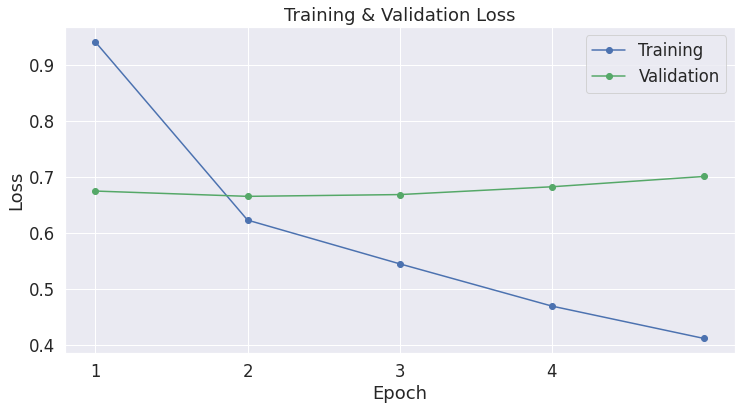

In [ ]:
import matplotlib.pyplot as plt

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()


In [ ]:

# 파라미터 표시
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (42005, 768)
transformer.wpe.weight                                   (2048, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [ ]:
# 모델 저장
output_dir='/content/drive/MyDrive/KUBIG/NLP/KUBIG Project/ind_model_save'
# output_dir='/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/hip_model_save'

# 디렉토리 만들기
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# 모델, 토크나이저 등 저장
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer_gpt3.save_pretrained(output_dir)

Saving model to /content/drive/MyDrive/KUBIG/NLP/KUBIG Project/ind_model_save


('/content/drive/MyDrive/KUBIG/NLP/KUBIG Project/ind_model_save/tokenizer_config.json',
 '/content/drive/MyDrive/KUBIG/NLP/KUBIG Project/ind_model_save/special_tokens_map.json',
 '/content/drive/MyDrive/KUBIG/NLP/KUBIG Project/ind_model_save/vocab.txt',
 '/content/drive/MyDrive/KUBIG/NLP/KUBIG Project/ind_model_save/added_tokens.json',
 '/content/drive/MyDrive/KUBIG/NLP/KUBIG Project/ind_model_save/tokenizer.json')

In [ ]:
!ls -l --block-size=K '/content/drive/MyDrive/KUBIG/NLP/KUBIG Project/ind_model_save'
# !ls -l --block-size=K '/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/hip_model_save'

total 514617K
-rw------- 1 root root      1K Aug 31 06:29 added_tokens.json
-rw------- 1 root root      1K Aug 31 06:29 config.json
-rw------- 1 root root 513622K Aug 31 06:29 pytorch_model.bin
-rw------- 1 root root      1K Aug 31 06:29 special_tokens_map.json
-rw------- 1 root root      1K Aug 31 06:29 tokenizer_config.json
-rw------- 1 root root    656K Aug 31 06:29 tokenizer.json
-rw------- 1 root root    337K Aug 31 06:29 vocab.txt


In [ ]:
!ls -l --block-size=M '/content/drive/MyDrive/KUBIG/NLP/KUBIG Project/ind_model_save/pytorch_model.bin'
# !ls -l --block-size=M '/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/hip_model_save/pytorch_model.bin'

-rw------- 1 root root 502M Aug 31 06:29 '/content/drive/MyDrive/KUBIG/NLP/KUBIG Project/ind_model_save/pytorch_model.bin'
